<a href="https://colab.research.google.com/github/angnat/JupyterNotebook/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning with feature extraction,now it's time to learn about new kind of transfer learning: Fine Tuning

In [ ]:
#Check if we're using GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-16 03:27:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-16 03:27:21 (68.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
# Import helper function we're going to use in the script
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir


##Let's get some data
tf.keras.application didalamnya ada resnet50, EfficientNetB0

In [ ]:
# Get 10% of training data of 10 clasess of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-03-16 03:27:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.207, 172.253.123.207, 142.250.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   165MB/s    in 1.0s    

2024-03-16 03:27:22 (165 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our datase
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

test_data_10_percent =  tf.keras.preprocessing.image_dataset_from_directory(
     directory=test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
#Check nama kelas nya dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images , labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[7.28418350e+01 1.61989803e+01 2.51989784e+01]
   [7.48877563e+01 1.60969391e+01 2.56938782e+01]
   [7.56428604e+01 1.42142859e+01 2.23520393e+01]
   ...
   [8.32142639e+01 1.77857361e+01 2.60000000e+01]
   [7.91428833e+01 1.73572083e+01 2.22857666e+01]
   [8.84286728e+01 3.05002098e+01 3.41430321e+01]]

  [[7.29540863e+01 1.29540806e+01 2.49540806e+01]
   [7.32142868e+01 1.32142849e+01 2.33571415e+01]
   [7.34846954e+01 1.34132652e+01 2.14132652e+01]
   ...
   [8.41581421e+01 1.87296124e+01 2.69438763e+01]
   [7.91377792e+01 1.72194271e+01 2.22143250e+01]
   [8.58112946e+01 2.78828297e+01 3.15256519e+01]]

  [[6.84897995e+01 1.74183693e+01 2.24795933e+01]
   [7.23673477e+01 2.53673496e+01 2.68112259e+01]
   [7.04489822e+01 2.72346973e+01 2.65408192e+01]
   ...
   [8.34489670e+01 1.87857132e+01 2.67857132e+01]
   [7.81428833e+01 1.71428833e+01 2.41428833e+01]
   [8.54287109e+01 2.64287109e+01 3.04287109e+01]]

  ...

  [[7.72142639e+01 1.97857361e+01 2.57857361e+01]
   [7

##Model 0: Building a transfer learning model using the Keras Functional API

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])


24274472/24274472 [==============================] - 1s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240317-080227
Epoch 1/5
24/24 [==============================] - 105s 4s/step - loss: 1.8574 - accuracy: 0.4253 - val_loss: 1.3115 - val_accuracy: 0.7303
Epoch 2/5
24/24 [==============================] - 88s 4s/step - loss: 1.1379 - accuracy: 0.7467 - val_loss: 0.8944 - val_accuracy: 0.8273
Epoch 3/5
24/24 [==============================] - 82s 3s/step - loss: 0.8289 - accuracy: 0.8253 - val_loss: 0.7355 - val_accuracy: 0.8355
Epoch 4/5
24/24 [==============================] - 89s 4s/step - loss: 0.6745 - accuracy: 0.8560 - val_loss: 0.6328 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 168s 7s/step - loss: 0.5845 - accuracy: 0.8560 - val_loss: 0.5716 - val_accuracy: 0.8553


In [ ]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [ ]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

In [ ]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


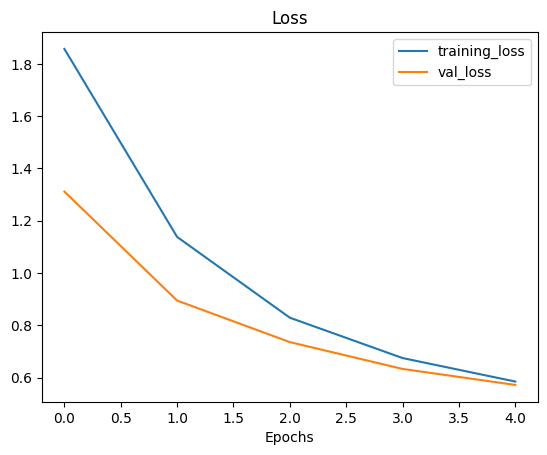

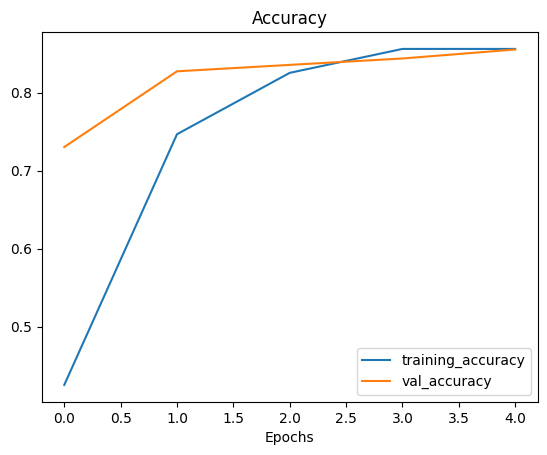

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

##Getting a feature vector from a trained model
The tf.keras.layers.GlobalAveragePooling2D() layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

In [ ]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


You can see the tf.keras.layers.GlobalAveragePooling2D() layer condensed the input tensor from shape (1, 4, 4, 3) to (1, 3). It did so by averaging the input_tensor across the middle two axes.

We can replicate this operation using the tf.reduce_mean() operation and specifying the appropriate axes.

In [ ]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

🛠 Practice: Do the same as the above cell but for tf.keras.layers.GlobalMaxPool2D()

In [ ]:
global_max_2d = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_max_2d}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

2D global average pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


# Running a series of transfer learning experiments
We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:

- Model 1: Use feature extraction transfer learning on 1% of the training data with data augmentation.
- Model 2: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.
- Model 3: Fine-tune the Model 2 checkpoint on 10% of the training data with data augmentation.
- Model 4: Fine-tune the Model 2 checkpoint on 100% of the training data with data augmentation.

### Getting and preprocessing data for model 1

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2024-03-17 08:13:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.207, 142.251.172.207, 142.251.180.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   115MB/s    in 1.1s    

2024-03-17 08:13:45 (115 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [ ]:
# How many images are we working with?
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'

In [ ]:
# Setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## ADD Data Augmentation right into the model

To add data augmentation right into our models, we can use the layers
* tf.keras.layers.experimental.preprocessing

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping rotation zooms
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet
], name='data_augmentation' )

### Visualize our data augmentation layer (and see what happens to our data)

tf.Tensor(
[[[ 16.219276    9.219277    3.2192771]
  [ 16.485891    9.485891    3.4858913]
  [ 16.37035     9.37035     3.37035  ]
  ...
  [ 18.345598    7.8298783   2.2941718]
  [ 24.167334   12.448531    6.5685344]
  [ 30.001343   17.088587   11.392292 ]]

 [[ 15.642002    8.642003    2.6420026]
  [ 15.813068    8.813068    2.8130689]
  [ 15.919355    8.919355    2.9193559]
  ...
  [ 17.529184    7.510154    1.7233863]
  [ 21.742212   10.646351    4.729225 ]
  [ 27.443779   15.354182    9.415188 ]]

 [[ 15.170001    8.170001    2.1700013]
  [ 15.220701    8.220701    2.2207007]
  [ 15.401859    8.401859    2.401859 ]
  ...
  [ 17.211937    7.6440253   1.4898007]
  [ 19.44625     8.94293     2.9443126]
  [ 24.352257   12.770845    6.7877455]]

 ...

 [[180.26584    97.63129    49.888565 ]
  [169.23814    87.51546    42.028923 ]
  [168.30945    87.382416   44.28337  ]
  ...
  [246.99199   161.58017    84.13518  ]
  [249.60612   165.83633    88.70278  ]
  [250.71678   168.50696    91.74

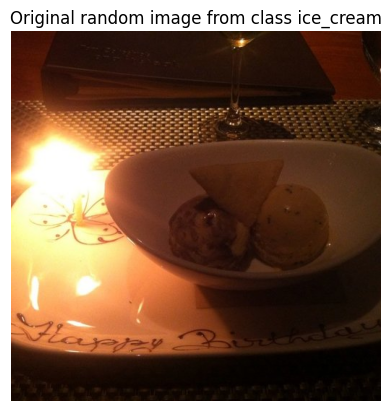

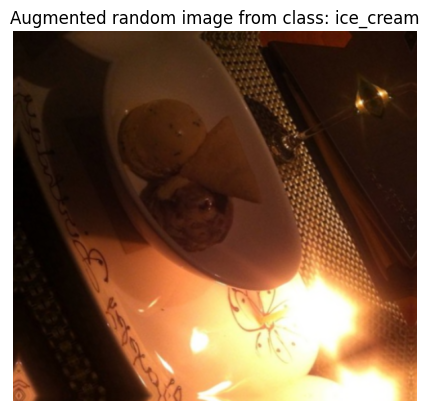

In [ ]:
# View a random image and compare it to its augmentation version
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.squeeze(img))
plt.figure()
# di normalisasi
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);
print(augmented_img)

### Model 1: Feature extraction transfer learning on 1% of the data with data augmentaion

In [ ]:
# Setup input shape and base model, freezing the base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training = False)

# pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) #Jika hanya layer maka dapat dipassing datanya disebelah kanan

# Put a dense layers on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                       experiment_name='1_percent_data_aug')])

16705208/16705208 [==============================] - 0s 0us/step


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240317-081356
Epoch 1/5
3/3 [==============================] - 101s 44s/step - loss: 2.3654 - accuracy: 0.0714 - val_loss: 2.2390 - val_accuracy: 0.1661
Epoch 2/5
3/3 [==============================] - 60s 28s/step - loss: 2.1170 - accuracy: 0.3000 - val_loss: 2.1093 - val_accuracy: 0.2467
Epoch 3/5
3/3 [==============================] - 89s 43s/step - loss: 1.9525 - accuracy: 0.4000 - val_loss: 1.9912 - val_accuracy: 0.3289
Epoch 4/5
3/3 [==============================] - 87s 42s/step - loss: 1.7616 - accuracy: 0.5000 - val_loss: 1.9098 - val_accuracy: 0.3832
Epoch 5/5
3/3 [==============================] - 86s 42s/step - loss: 1.5708 - accuracy: 0.6714 - val_loss: 1.8063 - val_accuracy: 0.4688


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
#Evaluate on the full dataset
result_1_percent_data_aug = model_1.evaluate(test_data)
result_1_percent_data_aug

79/79 [==============================] - 221s 3s/step - loss: 1.8254 - accuracy: 0.4248


[1.8254302740097046, 0.42480000853538513]

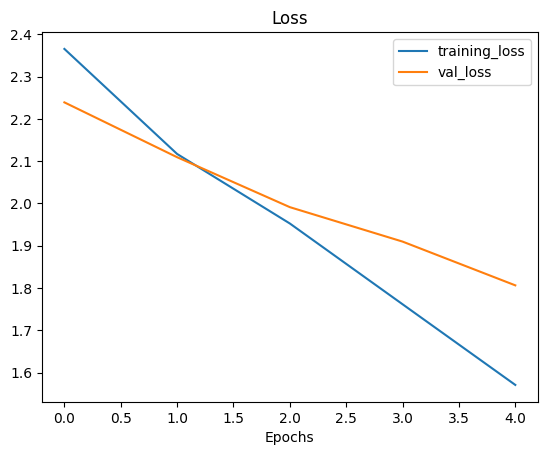

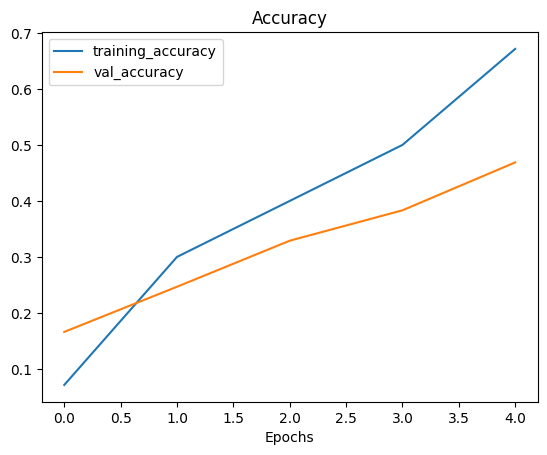

In [ ]:
# How do the model with 1% of the data augmentation
plot_loss_curves(history_1_percent)

## Model 2 : Feature extraction transfer learning model with 10% of data

In [ ]:

# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
#Create training and test dirs
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [ ]:
# How many images are we working with?
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
# Setup data loaders
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# ADD Data Augmentation right into the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping rotation zooms
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet
], name='data_augmentation' )


tf.Tensor(
[[[184.79321   182.7932    170.7932   ]
  [185.25053   183.25053   171.17813  ]
  [185.70078   183.70078   171.12036  ]
  ...
  [ 34.40667    17.78504     7.1682343]
  [ 35.627106   18.148132    6.0474653]
  [ 33.65284    15.23789     3.313004 ]]

 [[185.00626   183.00624   170.98691  ]
  [185.00092   183.00092   170.58734  ]
  [185.23695   183.23695   170.3629   ]
  ...
  [ 44.100666   29.030258   17.455359 ]
  [ 42.760868   26.118122   13.547104 ]
  [ 37.73756    19.972116    7.601469 ]]

 [[184.994     182.994     170.79185  ]
  [184.99913   182.99913   170.21158  ]
  [185.13783   183.13783   170.16519  ]
  ...
  [ 45.550423   31.336197   19.814253 ]
  [ 44.9065     29.098194   16.566336 ]
  [ 39.298866   22.429335    9.833925 ]]

 ...

 [[190.43495   184.43645   168.43196  ]
  [191.54224   185.54247   169.54181  ]
  [191.9277    185.9334    169.91632  ]
  ...
  [165.99008   162.99008   145.99008  ]
  [165.89001   162.89001   145.89001  ]
  [165.8142    162.8142    145.81

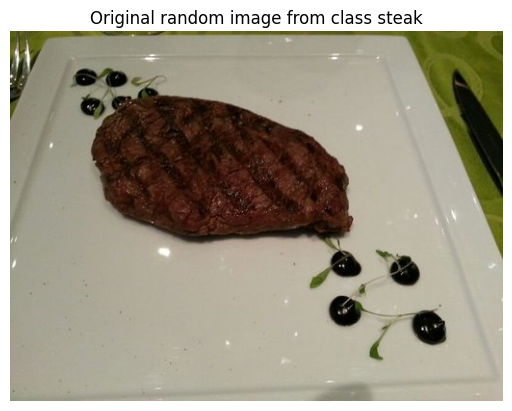

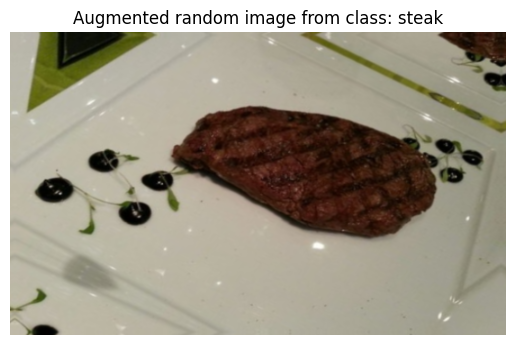

In [ ]:
# View a random image and compare it to its augmentation version
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
import os
import random
target_class = random.choice(train_data_10_percent.class_names)
target_dir = '10_food_classes_10_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.squeeze(img))
plt.figure()
# di normalisasi
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);
print(augmented_img)

### Model 2: Feature extraction transfer learning on 10% of the data with data augmentaion

In [ ]:
# Setup input shape and base model, freezing the base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs) #augmented image tidak muncul di test image

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training = False) # pass augmented images to base model but keep it in inferance mode, juga memastikan batch form layer don't get update

# pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) #Jika hanya single layer maka dapat dipassing datanya disebelah kanan

# Put a dense layers on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_2 = keras.Model(inputs,outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

###Creating a model checkpoint callback
The modelcheckpoint callback intermediately saves our model

In [ ]:
# Set checkpoint path
checkpoint_path = 'ten_percent_model_checkpoint_weight/checkpoint.ckpt'

#Create a ModelCheckpoint callback to save model weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', #save every epoch
                                                         verbose=1 #how much the output)
)

###Fit model 2 passing in ModelCheckpoint callback

In [ ]:
# Fit the model


initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                epochs=initial_epochs,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                       experiment_name='10_percent_data_aug'),
                                           checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240317-095042
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0014 - accuracy: 0.3253
Epoch 1: saving model to ten_percent_model_checkpoint_weight/checkpoint.ckpt
24/24 [==============================] - 102s 4s/step - loss: 2.0014 - accuracy: 0.3253 - val_loss: 1.4367 - val_accuracy: 0.6941
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3185 - accuracy: 0.6867
Epoch 2: saving model to ten_percent_model_checkpoint_weight/checkpoint.ckpt
24/24 [==============================] - 97s 4s/step - loss: 1.3185 - accuracy: 0.6867 - val_loss: 1.0054 - val_accuracy: 0.7829
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0018 - accuracy: 0.7560
Epoch 3: saving model to ten_percent_model_checkpoint_weight/checkpoint.ckpt
24/24 [==============================] - 90s 4s/step - loss: 1.0018 - accuracy: 0.7560 - val_loss: 0.8056 - val_accuracy: 0.8125
Epoch 4/5
24/24

In [ ]:
 #Cara lama
history_10_percent = model_2.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                       experiment_name='10_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240317-100239
Epoch 1/5
24/24 [==============================] - 86s 4s/step - loss: 0.6673 - accuracy: 0.8307 - val_loss: 0.6263 - val_accuracy: 0.8306
Epoch 2/5
24/24 [==============================] - 88s 4s/step - loss: 0.6024 - accuracy: 0.8533 - val_loss: 0.5835 - val_accuracy: 0.8207
Epoch 3/5
24/24 [==============================] - 98s 4s/step - loss: 0.5610 - accuracy: 0.8627 - val_loss: 0.5469 - val_accuracy: 0.8405
Epoch 4/5
24/24 [==============================] - 93s 4s/step - loss: 0.5179 - accuracy: 0.8853 - val_loss: 0.5048 - val_accuracy: 0.8503
Epoch 5/5
24/24 [==============================] - 93s 4s/step - loss: 0.4946 - accuracy: 0.8773 - val_loss: 0.4973 - val_accuracy: 0.8536


In [ ]:
#Evaluate on the full dataset
result_10_percent_data_aug = model_2.evaluate(test_data)
result_10_percent_data_aug

79/79 [==============================] - 162s 2s/step - loss: 0.4929 - accuracy: 0.8660


[0.49288704991340637, 0.8659999966621399]

In [ ]:
# Compare sama base model nya
model_0.evaluate(test_data)

79/79 [==============================] - 120s 2s/step - loss: 0.5795 - accuracy: 0.8596


[0.5795420408248901, 0.8596000075340271]

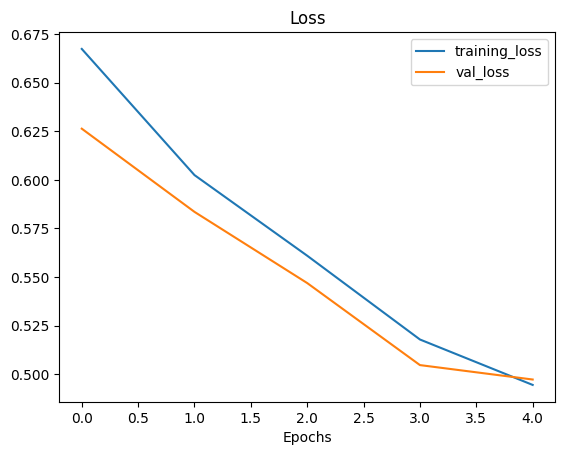

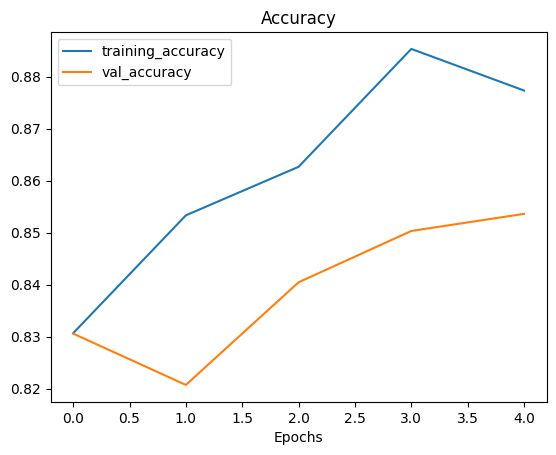

In [ ]:
# How do the model with 1% of the data augmentation
plot_loss_curves(history_10_percent)

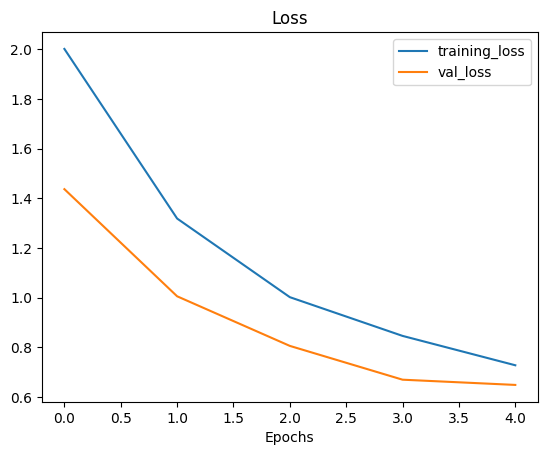

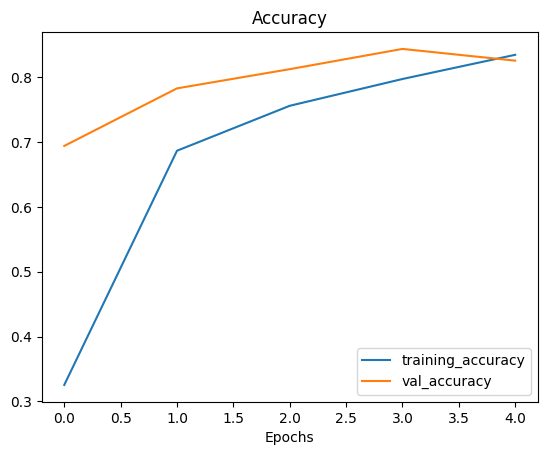

In [ ]:
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weight
Loading in Checkpoint weight returns a model in a spesific checkpoint

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 159s 2s/step - loss: 0.6219 - accuracy: 0.8452


In [ ]:
# If the result from our previous evaluated model_2 = loaded weight the success
result_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
result_10_percent_data_aug

[0.49288704991340637, 0.8659999966621399]

In [ ]:
loaded_weights_model_results

[0.6219184994697571, 0.8452000021934509]

In [ ]:
# Check to see if loaded model result are very close to our previous
import numpy as np
np.isclose(np.array(result_10_percent_data_aug),np.array(loaded_weights_model_results))

array([False, False])

## Model 3: Fine-tuning an existing model on 10% of the data
Fine tuning usually works best after training a feature extraction model for a few epochs with large amount of data. Jadi bikin Feature extraction nya dulu

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are these layers trainable? Dicek layer yg di Freeze
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7b006ff1e770> True
<keras.src.engine.sequential.Sequential object at 0x7b006ffdd1b0> True
<keras.src.engine.functional.Functional object at 0x7b006fb73e20> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7b006fec8d90> True
<keras.src.layers.core.dense.Dense object at 0x7b006fbade40> True


In [ ]:
# Layer apa saja yg ada di Base Model (EfficientNetB0) dan apakah trainable
for layer in model_2.layers[2].layers:
  print(layer.name, layer.trainable)

input_3 False
rescaling_3 False
normalization_2 False
rescaling_4 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [ ]:
# How many trainable variable are trainable
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine tuning, let's start by setting last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (kita harus compile ulang model yg lainnya)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), #ketika fine tuning biasanya kita menurunkan learning rate by 10x
                metrics=['accuracy'])

In [ ]:
model_2.layers[2]

🔑 **Note** if using finetuning it's best practice to lower your learning rate by some amount. Best practice 10x dari normal value

In [ ]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2]):
  print(layer_number,layer.name, layer.trainable)

TypeError: 'Functional' object is not iterable

In [ ]:
print(len(model_2.trainable_variables))

In [ ]:
# Fina tune for antoher 5 epoch
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], #start training from previous epoch
                                               callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                      experiment_name='10_percent_fine_tune_last_epoch')])

In [ ]:
# Evaluate the fine tuned model (model_3 which is actually model_2 fine tuned for another 5 epoch)
result_fine_tune_10_percent = model_2.evaluate(test_data)

In [ ]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [ ]:
# Let's create a function to compare training history
def compare_history(original_history,new_history,initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  #Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  #combine original history
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  #Make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Val Accuracy')
  plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

   #Make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Val Loss')
  plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Loss')

In [ ]:
compare_history(history_10_percent_data_aug,
                history_fine_10_percent_data_aug,
                initial_epochs=5)

## Model 4 : Fine Tuning and existing model on all of data

In [ ]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
# How many image are we working with
walk_through_dir('10_food_classes_all_data')

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

In [ ]:
# Evaluate model 2
model_2.evaluate(test_data)

In [ ]:
result_fine_tune_10_percent

To train fine tuning model (model_4) we need to revert model_2 back to its feature extraction

In [ ]:
model_2.load_weights(checkpoint_path)